In [1]:
from os.path import join

import pandas as pd
import numpy as np
import pickle

import scipy
from scipy import stats
from scipy import signal

import random

from matplotlib import pyplot as plt
from matplotlib import patches
from matplotlib import animation, rc

from torch import nn
from torch.autograd import Variable

kookmin:  
국민대 학생 데이터(run 1개만 수행함) - 데이터 퀄리티는 더 좋음(Noise가 더 적음)

/mnt/sdb2/joystick/rawdata/test_kookmin/behavior_data_run1.pkl  
/mnt/sdb2/joystick/rawdata/test_kookmin/km_RMH_run1.csv


Seojin:  
국민대 학생 데이터(run 2개 수행함) - 데이터 퀄리티는 더 좋음(Noise가 더 많음

/mnt/sdb2/joystick/rawdata/test_seojin/EMG_run1.csv  
/mnt/sdb2/joystick/rawdata/test_seojin/EMG_run2.csv  

/mnt/sdb2/joystick/rawdata/test_seojin/behavior_data_run1.pkl  
/mnt/sdb2/joystick/rawdata/test_seojin/behavior_data_run2.pkl  

---

## 1. Loading joystick data

In [2]:
## 29300 frames = 58.6 frames/sec * 25 sec/trial * 20 trials
joystick = np.load(join('/mnt/sdb2/joystick/rawdata/test_kookmin','behavior_data_run1.pkl')
                   , allow_pickle=True)

for key, value in joystick.items():
    ## restore values as a numpy array
    joystick[key] = np.array(value)
    ## make sure it is 1D array
    if joystick[key].shape[-1] < 2:
        joystick[key] = np.concatenate(joystick[key])
    print(joystick[key].shape)
joystick

(29300, 2)
(29300, 2)
(29300, 2)
(29300,)
(29300,)


{'cursor': array([[994, 575],
        [994, 575],
        [994, 575],
        ...,
        [702, 785],
        [701, 785],
        [701, 785]]),
 'target': array([[960, 540],
        [958, 539],
        [956, 538],
        ...,
        [674, 713],
        [674, 713],
        [673, 713]]),
 'joystick': array([[-0.00341797,  0.00331116],
        [-0.00341797,  0.00331116],
        [-0.00341797,  0.00331116],
        ...,
        [-0.55766296, -0.00341797],
        [-0.5098114 , -0.00341797],
        [-0.48919678, -0.02392578]]),
 'hit': array([1, 1, 1, ..., 0, 0, 0]),
 'time': array([1.88689232e-02, 3.59268188e-02, 5.32288551e-02, ...,
        6.91469816e+02, 6.91488928e+02, 6.91503995e+02])}

In [3]:
# print(joystick['target'][::1465])
# print(joystick['target'][::1464])

## 2. Loading preprocessed EMG data

In [4]:
## 950 frames/sec (=HZ)
EMG = np.genfromtxt(join('/mnt/sdb2/joystick/preprocessed/test_kookmin','km_EMG_run1_processed_30.csv')
                     , delimiter=',', skip_header=True)
## cutting the 1st column off
EMG = EMG[:,1:].T
EMG.shape

(669870, 10)

In [5]:
## # frames per trial
nframe = 950*25
## index range of a trial
idx_trial = np.arange(nframe)

In [6]:
## cut data from resting off. 475000 frames = 950 Hz * 25 sec/trial * 20 trials
tmp = np.ones((nframe*20, 10))*np.nan
print(tmp.shape)

for trial in range(20):
    print('trial%02d:'%trial, idx_trial+nframe*trial, idx_trial+(nframe+950*10)*trial)
    tmp[idx_trial+nframe*trial,:] = EMG[idx_trial+(nframe+950*10)*trial,:]
EMG = tmp
## check blanks
print(EMG[EMG==np.nan])

(475000, 10)
trial00: [    0     1     2 ... 23747 23748 23749] [    0     1     2 ... 23747 23748 23749]
trial01: [23750 23751 23752 ... 47497 47498 47499] [33250 33251 33252 ... 56997 56998 56999]
trial02: [47500 47501 47502 ... 71247 71248 71249] [66500 66501 66502 ... 90247 90248 90249]
trial03: [71250 71251 71252 ... 94997 94998 94999] [ 99750  99751  99752 ... 123497 123498 123499]
trial04: [ 95000  95001  95002 ... 118747 118748 118749] [133000 133001 133002 ... 156747 156748 156749]
trial05: [118750 118751 118752 ... 142497 142498 142499] [166250 166251 166252 ... 189997 189998 189999]
trial06: [142500 142501 142502 ... 166247 166248 166249] [199500 199501 199502 ... 223247 223248 223249]
trial07: [166250 166251 166252 ... 189997 189998 189999] [232750 232751 232752 ... 256497 256498 256499]
trial08: [190000 190001 190002 ... 213747 213748 213749] [266000 266001 266002 ... 289747 289748 289749]
trial09: [213750 213751 213752 ... 237497 237498 237499] [299250 299251 299252 ... 3

- Fourier Transform

In [8]:
def get_fft(y, fs):
    """ Get the FFT of a given signal and corresponding frequency bins.

    Parameters:
        y  - signal
        fs - sampling frequency
    Returns:
        (mag, freq) - tuple of spectrum magitude and corresponding frequencies
    """
    n  = len(y)      # Get the signal length
    dt = 1/float(fs) # Get time resolution

    fft_output = np.fft.rfft(y)     # Perform real fft
    rfreqs = np.fft.rfftfreq(n, dt) # Calculatel frequency bins
    fft_mag = np.abs(fft_output)    # Take only magnitude of spectrum

    # Normalize the amplitude by number of bins and multiply by 2
    # because we removed second half of spectrum above the Nyqist frequency 
    # and energy must be preserved
    fft_mag = fft_mag * 2. / n

    return np.array(fft_mag), np.array(rfreqs)

In [24]:
## sampling freq.
Fs = 950
## sample interval time
T = 1./Fs
## end of time
te = 25
## time vector
t = np.arange(0, te, T)

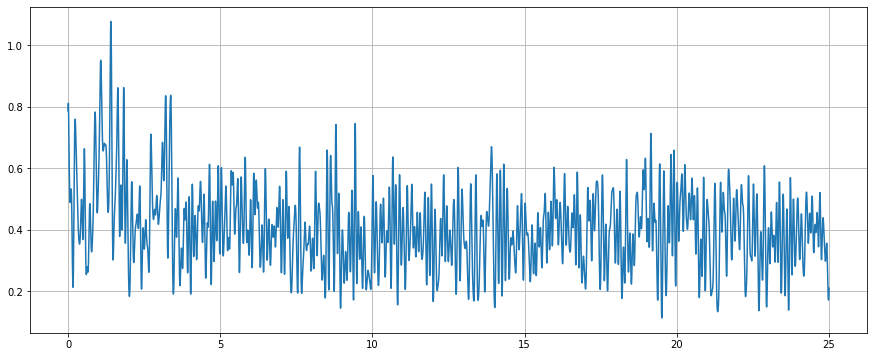

In [25]:
## Fourier Transform
tmp = EMG[:Fs*te,2]
fig = plt.figure(figsize=(15,6))
plt.plot(t, tmp)
plt.grid()

In [26]:
mag, freq = get_fft(tmp, Fs)

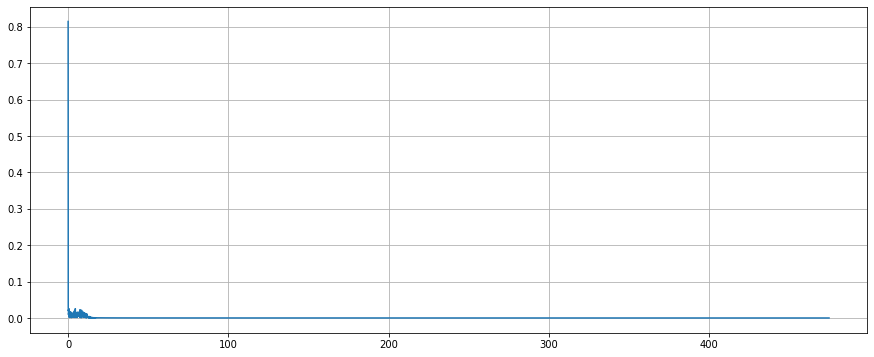

In [27]:
fig = plt.figure(figsize=(15,6))
plt.plot(freq,mag)
# plt.xlim((-0.50))
plt.grid()

---

In [13]:
fs = 100
T = 1./fs
te = 2
t = np.arange(0,te,T)

In [14]:
y1 = np.sin(2*np.pi*(1*t))
y2 = 2*np.sin(2*np.pi*(5*t))
y3 = 1.5*np.sin(2*np.pi*(15*t))
y = y1+y2+y3

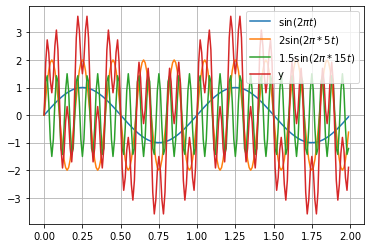

In [23]:
plt.plot(t,y1)
plt.plot(t,y2)
plt.plot(t,y3)
plt.plot(t,y)
plt.legend(['sin($2\pi t$)','2sin($2\pi *5t$)','1.5sin($2\pi *15t$)','y'])
plt.grid()

In [16]:
mag, freq = get_fft(y, fs)

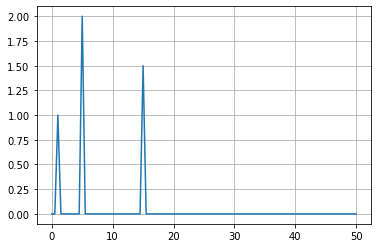

In [17]:
plt.plot(freq, mag)
plt.grid()
# plt.xlim(0,10)

---

- Downsampling

In [7]:
EMG = signal.resample(tmp, joystick['time'].shape[0])
EMG.shape

(29300, 10)

---

## 3. Animation

In [8]:
# resolution = np.array([1920, 1080])
# scale = 1./120

# fig = plt.figure(figsize=np.array(resolution*scale).astype(np.int))
# ax = plt.axes(xlim=(0, resolution[0]), ylim=(0, resolution[1]))
# # fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)

# ## background
# ax.set_facecolor((0., 0., 0.))

# live = []

# def init():
#     line, = ax.plot([], [], color='w', marker='+', markersize=12, lw=3)
#     line.set_data([], [])
    
#     target = patches.Circle((-100,-100), radius=35., fc='black', ec='white')
    
#     live.append(line)
#     live.append(ax.add_patch(target))
    
#     return live

# def animate(i):

#     live[0].set_data(joystick['cursor'][i,:])
#     live[1].set_center(joystick['target'][i,:]+np.array([35., 35.]))

#     if joystick['hit'][i]:
#         live[1].set(facecolor='crimson')
#     else:
#         live[1].set(facecolor='black')

#     return live

/tmp/ipykernel_2557463/1215721040.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ratio = np.array([16+8, 9]).astype(np.int)


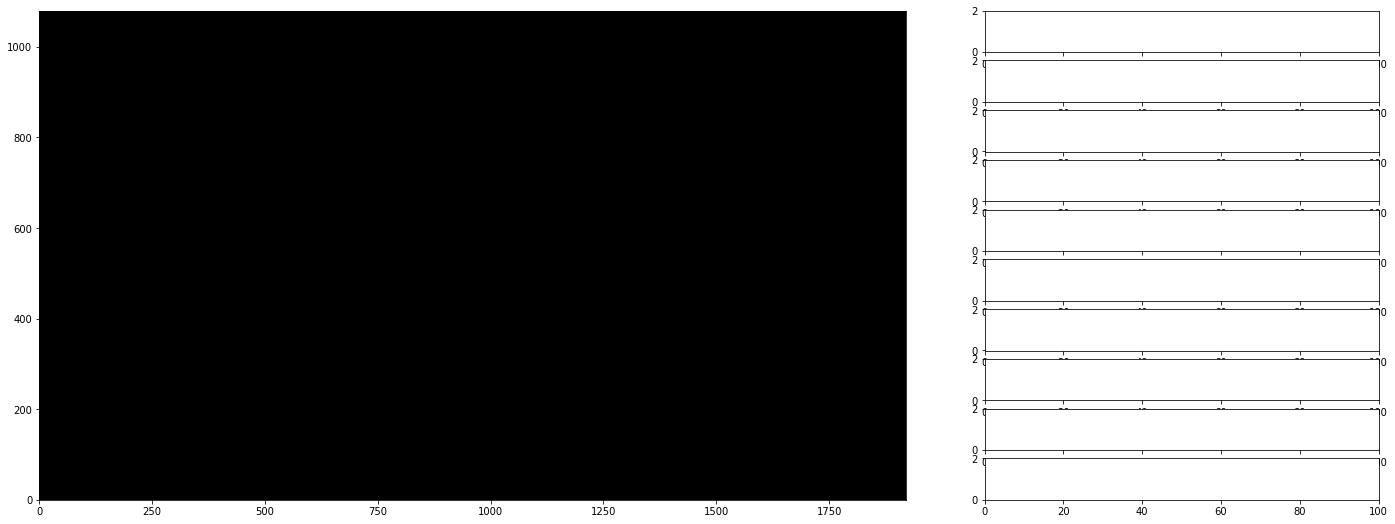

In [17]:
ratio = np.array([16+8, 9]).astype(np.int)
resolution = 120 * ratio
scale = 1./120

fig = plt.figure(figsize=ratio)

plot_grid_size = (10, 3)

## screen
rowspan_screen = 10

colspan_screen = 2

ax_screen = plt.subplot2grid(plot_grid_size, 
                             (0, 0), 
                             rowspan = rowspan_screen, 
                             colspan = colspan_screen)
ax_screen.set_xlim((0, 1920))
ax_screen.set_ylim((0, 1080))
ax_screen.set_facecolor((0., 0., 0.))

## auxiliary axis
auxiliary_plot_max_frame = 100
rowspan_auxiliary = 1
colspan_auxiliary = 1

# ## Hit
# ax_hit = plt.subplot2grid(plot_grid_size, 
#                           (0, plot_grid_size[1] - colspan_auxiliary), 
#                           rowspan = rowspan_auxiliary, 
#                           colspan = colspan_auxiliary)
# ax_hit.set_xlim((0, auxiliary_plot_max_frame))
# ax_hit.set_ylim((0, 2))

# ax_hit.set_ylabel("Hit", rotation=90, loc='center', fontsize=7)

## emg
ylim_emg = (-0.01, 2)
axs_emg = []
for idx in range(10):
    ax_emg = plt.subplot2grid(plot_grid_size, 
                           (idx, plot_grid_size[1] - colspan_auxiliary), 
                           rowspan = rowspan_auxiliary, 
                           colspan = colspan_auxiliary)
    ax_emg.set_xlim((0, auxiliary_plot_max_frame))
    ax_emg.set_ylim(ylim_emg)
    axs_emg.append(ax_emg)

# axs_emg[0].set_ylabel("DELTOID", rotation=90, loc='center', fontsize=7)
# axs_emg[1].set_ylabel("BICEPS", rotation=90, loc='center', fontsize=7)
# axs_emg[2].set_ylabel("TRICEPS", rotation=90, loc='center', fontsize=7)
# axs_emg[3].set_ylabel("FLEXOR CARPI", rotation=90, loc='center', fontsize=7)
# axs_emg[4].set_ylabel("PALMARIS LONGUS", rotation=90, loc='center', fontsize=7)
# axs_emg[5].set_ylabel("EXTENSOR CARPI", rotation=90, loc='center', fontsize=7)

In [18]:
live = []
def init():
    ## Screen
    cursor, = ax_screen.plot([], [], color='w', marker='+', markersize=12, lw=3)
    cursor.set_data([], [])
    
    target = patches.Circle((-100,-100), radius=35., fc='black', ec='white')
    
#     ## Hit
#     hit, = ax_hit.plot([], [], color='b', lw=5)
#     hit.set_data([], [])
    
    ## emg
    emg_plots = []
    for ax_emg in axs_emg:
        emg_plot, = ax_emg.plot([], [])
        emg_plot.set_data([], [])
        emg_plots.append(emg_plot)

    ## live
    live.append(cursor)
    live.append(ax_screen.add_patch(target))
#     live.append(hit)
    
    for emg_plot in emg_plots:
        live.append(emg_plot)
    
    return live

def animate(i):
    cursor = live[0]
    target = live[1]
#     hit = live[2]
    
    emg_plots = live[2:12]
    
    """
    Screen
    """
    cursor.set_data(joystick['cursor'][i,:])
    target.set_center(joystick['target'][i,:]+np.array([35., 35.]))

    if joystick['hit'][i]:
        target.set(facecolor='crimson')
    else:
        target.set(facecolor='black')

    """
    Hit
    """
    onset_frame = 0
    
    past_frame = i - auxiliary_plot_max_frame
    current_frame = i
    
#     # ranging past ~ current frame
#     if past_frame < onset_frame:
#         ax_hit.set_xlim((onset_frame, auxiliary_plot_max_frame))
#         hit.set_data(np.arange(onset_frame, current_frame + 1), 
#                      joystick["hit"][onset_frame: current_frame + 1])
#     else:
#         ax_hit.set_xlim((past_frame, current_frame))
#         hit.set_data(np.arange(past_frame, current_frame + 1), 
#                      joystick["hit"][past_frame: current_frame + 1])
    
    """
    EMG
    """
    if past_frame < onset_frame:
        for emg_i in range(len(axs_emg)):
            ax_emg = axs_emg[emg_i]
            ax_emg.set_xlim((onset_frame, auxiliary_plot_max_frame))
            emg_plots[emg_i].set_data(np.arange(onset_frame, current_frame + 1), 
                                      EMG[:,emg_i][onset_frame: current_frame + 1])
            
    else:
        for emg_i in range(len(axs_emg)):
            ax_emg = axs_emg[emg_i]
            
            ax_emg.set_xlim((past_frame, current_frame))
            emg_plots[emg_i].set_data(np.arange(past_frame, current_frame + 1), 
                                      EMG[:,emg_i][past_frame: current_frame + 1])
#             ax_emg.set(color='r', marker='o', markersize=5)
        
            
    return live

In [19]:
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=600, interval=17.1, blit=True)

rc('animation', html='html5')
anim

In [20]:
anim.save(join('/home/sungbeenpark/tmp','replay.mp4'), writer = 'ffmpeg', fps=58.6)

---

## 4. Machine Learning

- SVR

In [8]:
print(EMG.shape, joystick['cursor'].shape)

(29300, 10) (29300, 2)


In [9]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.model_selection import train_test_split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(EMG
                                                    , joystick['cursor']
                                                    , test_size=0.2
                                                    , random_state=42
                                                    , shuffle=False)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(23440, 10) (23440, 2) (5860, 10) (5860, 2)


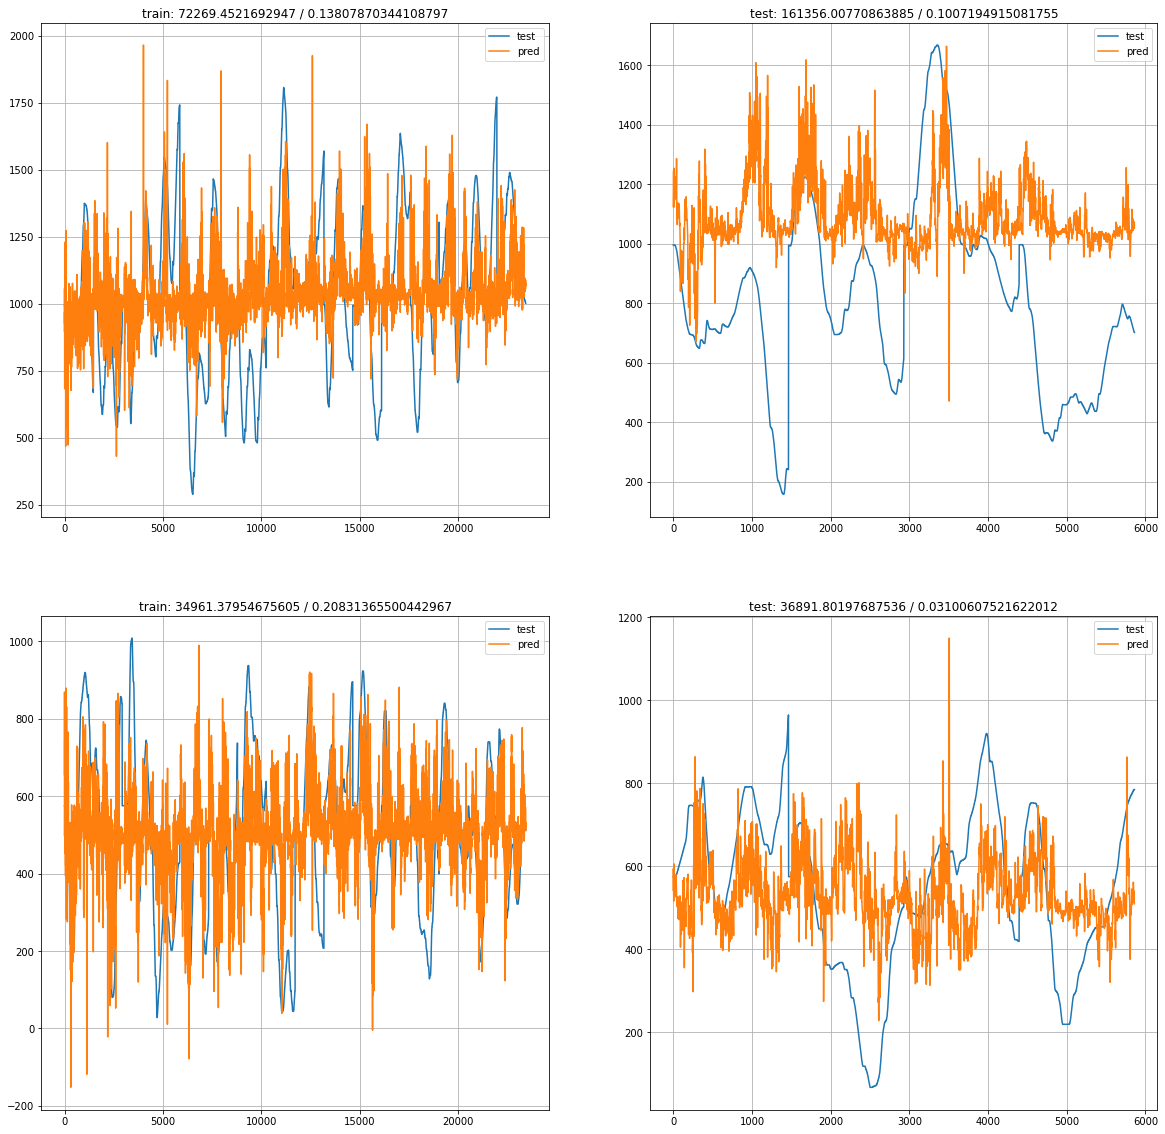

In [14]:
# Create Support Vector Regression model
# kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}, default=’rbf’
# C : 학습 오류에 대한 패널티, C 값이 클 수록 모델이 학습 데이터에 좀 더 최적화 됨, 너무 크면 오버피팅 발생
# Epsilon : 임계값, 예측한 값이 GT 범위 안에 있으면 패널티 부여 X
sv_regressor = SVR(kernel='poly', C=1.0, epsilon=0.1)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,20))
for idx, u in enumerate(['x','y']):
    ax = axs[idx,:]
    sv_regressor.fit(X_train, y_train[:,idx])
    
    y_pred = sv_regressor.predict(X_train)
    
    mse = mean_squared_error(y_train[:,idx], y_pred)
    score = explained_variance_score(y_train[:,idx], y_pred)
    
    ax[0].plot(y_train[:,idx])
    ax[0].plot(y_pred)
    ax[0].grid()
    ax[0].set_title('train: %s / %s'%(mse,score))
    ax[0].legend(['test', 'pred'])

    y_pred = sv_regressor.predict(X_test)

    mse = mean_squared_error(y_test[:,idx], y_pred)
    score = explained_variance_score(y_test[:,idx], y_pred)

    ax[1].plot(y_test[:,idx])
    ax[1].plot(y_pred)
    ax[1].grid()
    ax[1].set_title('test: %s / %s'%(mse,score))
    ax[1].legend(['test', 'pred'])

- Neural Network

In [9]:
## Selecting Data
import torch
from torch import nn
import torch.optim as optim

X_train = torch.tensor(np.array(X_train), dtype=torch.float)
X_test = torch.tensor(np.array(X_test), dtype=torch.float)
y_train = torch.tensor(np.array(y_train), dtype=torch.float)
y_test = torch.tensor(np.array(y_test), dtype=torch.float)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

torch.Size([23440, 10]) torch.Size([23440, 2]) torch.Size([5860, 10]) torch.Size([5860, 2])


---

# Load EMG Data

In [23]:
# emg_run1_file_path = "/mnt/sdb2/joystick/rawdata/test_seojin/EMG_run1.csv"
# emg_run2_file_path = "/mnt/sdb2/joystick/rawdata/test_seojin/EMG_run2.csv"
path_km = '/mnt/sdb2/joystick/rawdata/test_kookmin/km_RMH_run1.csv'

In [24]:
f = open(path_km, 'r', encoding="cp949")
lines = f.readlines()
f.close()

In [25]:
for line_i in range(len(lines)):
    if len(lines[line_i].split(",")) > 1:
        start_record_index = line_i
        break

In [26]:
emg_header = lines[0:start_record_index]
emg_column = lines[start_record_index:start_record_index+1]
emg_datas = lines[start_record_index+1:]

In [32]:
isemg = emg_column[0].split(',')
for i in range(len(isemg)):
    if 'Quattro' in isemg[i]:
        isemg[i] = True
    elif 'EMG' in isemg[i]:
        isemg[i] = True
    else:
        isemg[i] = False
len(isemg)

140

In [33]:
emg_column[0].split(',')

['X [s]',
 'R DELTOID: EMG 1 (IM) [Volts]',
 'X [s]',
 'R DELTOID: Acc 1.X (IM) [g]',
 'X [s]',
 'R DELTOID: Acc 1.Y (IM) [g]',
 'X [s]',
 'R DELTOID: Acc 1.Z (IM) [g]',
 'X [s]',
 'R DELTOID: Gyro 1.X (IM) [deg/sec]',
 'X [s]',
 'R DELTOID: Gyro 1.Y (IM) [deg/sec]',
 'X [s]',
 'R DELTOID: Gyro 1.Z (IM) [deg/sec]',
 'X [s]',
 'R DELTOID: Mag 1.X (IM) [uTesla]',
 'X [s]',
 'R DELTOID: Mag 1.Y (IM) [uTesla]',
 'X [s]',
 'R DELTOID: Mag 1.Z (IM) [uTesla]',
 'X [s]',
 'R BICEPS BRACHII: EMG 2 (IM) [Volts]',
 'X [s]',
 'R BICEPS BRACHII: Acc 2.X (IM) [g]',
 'X [s]',
 'R BICEPS BRACHII: Acc 2.Y (IM) [g]',
 'X [s]',
 'R BICEPS BRACHII: Acc 2.Z (IM) [g]',
 'X [s]',
 'R BICEPS BRACHII: Gyro 2.X (IM) [deg/sec]',
 'X [s]',
 'R BICEPS BRACHII: Gyro 2.Y (IM) [deg/sec]',
 'X [s]',
 'R BICEPS BRACHII: Gyro 2.Z (IM) [deg/sec]',
 'X [s]',
 'R BICEPS BRACHII: Mag 2.X (IM) [uTesla]',
 'X [s]',
 'R BICEPS BRACHII: Mag 2.Y (IM) [uTesla]',
 'X [s]',
 'R BICEPS BRACHII: Mag 2.Z (IM) [uTesla]',
 'X [s]',
 'R 

In [34]:
np.array(emg_column[0].split(','))[isemg]

array(['R DELTOID: EMG 1 (IM) [Volts]',
       'R BICEPS BRACHII: EMG 2 (IM) [Volts]',
       'R TRICEPS BRACHII: EMG 3 (IM) [Volts]',
       'R FLEXOR CARPI RADIALIS: EMG 4 (IM) [Volts]',
       'R PALMARIS LONGUS: EMG 5 (IM) [Volts]',
       'R EXTENSOR CARPI RADIALIS: EMG 6 (IM) [Volts]',
       'Quattro sensor 9: EMG.A 9 [V]', 'Quattro sensor 9: EMG.B 9 [V]',
       'Quattro sensor 9: EMG.C 9 [V]', 'Quattro sensor 9: EMG.D 9 [V]',
       'Quattro sensor 9: ACC.X 9 [g]', 'Quattro sensor 9: ACC.Y 9 [g]',
       'Quattro sensor 9: ACC.Z 9 [g]',
       'Quattro sensor 9: GYRO.X 9 [°/s]',
       'Quattro sensor 9: GYRO.Y 9 [°/s]',
       'Quattro sensor 9: GYRO.Z 9 [°/s]\n'], dtype='<U50')

In [8]:
onset = []
emg = []
for t in range(len(emg_datas)):
    tmp = np.array(emg_datas[t].split(','))[isemg].astype(np.float)
    emg.append(tmp)
    tmp = np.array(emg_datas[t].split(','))[isemg[1:]+[False]].astype(np.float)
    onset.append(tmp)

/tmp/ipykernel_358564/4091347950.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tmp = np.array(emg_datas[t].split(','))[isemg].astype(np.float)
/tmp/ipykernel_358564/4091347950.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tmp = np.array(emg_datas[t].split(','))[isemg[1:]+[False]].astype(np.float)


In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

emg = scaler.fit_transform(np.array(emg))
# emg[emg<0] = 0
onset = np.array(onset)

In [10]:
print(emg.shape, onset.shape)

(783660, 6) (783660, 6)


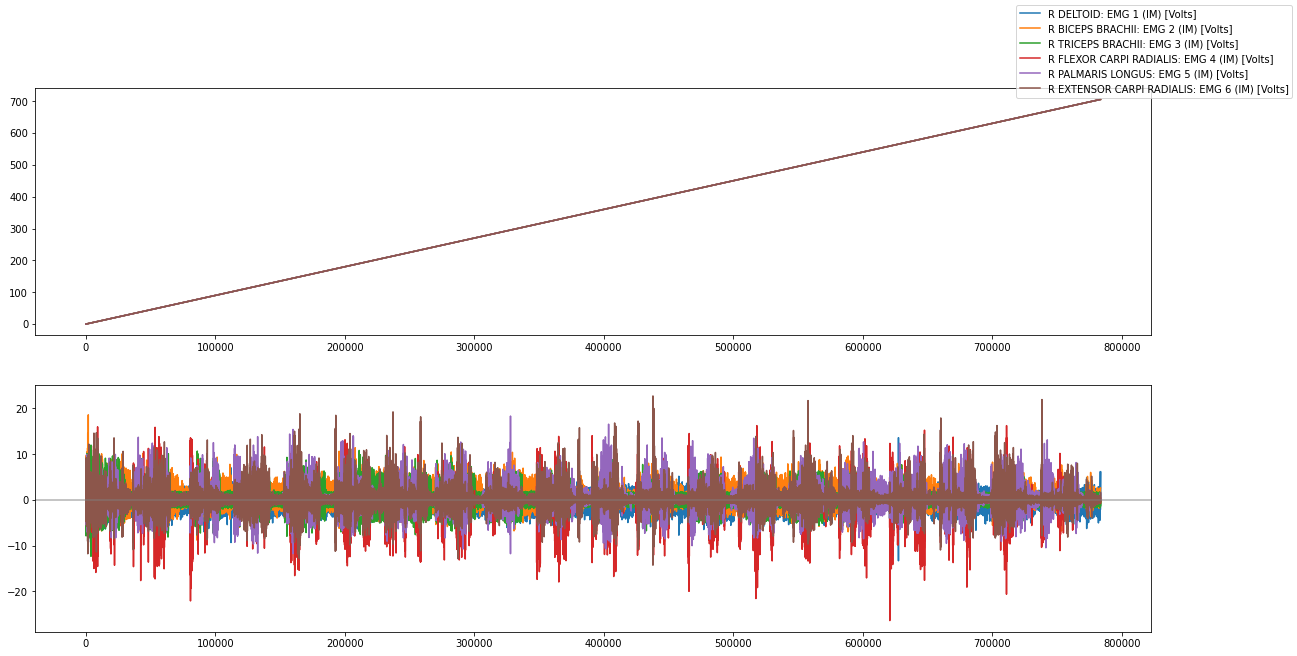

In [11]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(20,10))

axs[0].plot(onset)
axs[1].plot(emg)
axs[1].axhline(0, color='gray', alpha=0.6)
fig.legend(np.array(emg_column[0].split(','))[isemg])

# Load Behavior Data

In [14]:
behavior_run1_file_path = "/mnt/sdb2/joystick/rawdata/test_seojin/behavior_data_run1.pkl"
behavior_run2_file_path = "/mnt/sdb2/joystick/rawdata/test_seojin/behavior_data_run2.pkl"
path_km = '/mnt/sdb2/joystick/rawdata/test_kookmin/behavior_data_run1.pkl'

In [15]:
f = open(path_km, 'rb') 

behav = pickle.load(f)

In [16]:
print('run01:')
for key, value in behav.items():
    print(key, np.array(value).shape)

run01:
cursor (29300, 2)
target (29300, 2)
joystick (29300, 2)
hit (29300, 1)
time (29300, 1)


# EMG downsampling per frame

In [17]:
behav['time'] = np.array(behav['time']).reshape(-1)

In [80]:
emg_downsamples = []

for ch in range(6):
    res = []
    tmp = onset[:,ch]
    ttmp = emg[:,ch]
    for t in behav['time']:
        res.append(np.sqrt(np.mean(ttmp[tmp < t]**2)))
        ttmp = ttmp[tmp > t]
        tmp = tmp[tmp > t]
    res = np.array(res)
    
    emg_downsamples.append(res)

In [85]:
emg_downsamples = np.array(emg_downsamples)

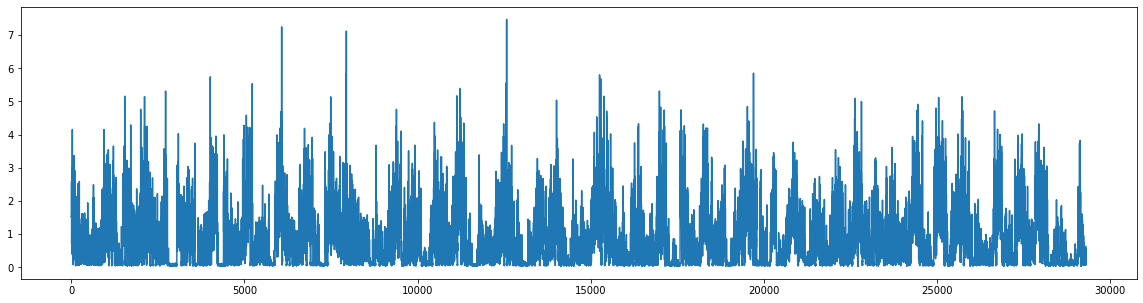

In [91]:
fig = plt.figure(figsize=(20,5))
plt.plot(emg_downsamples[4])

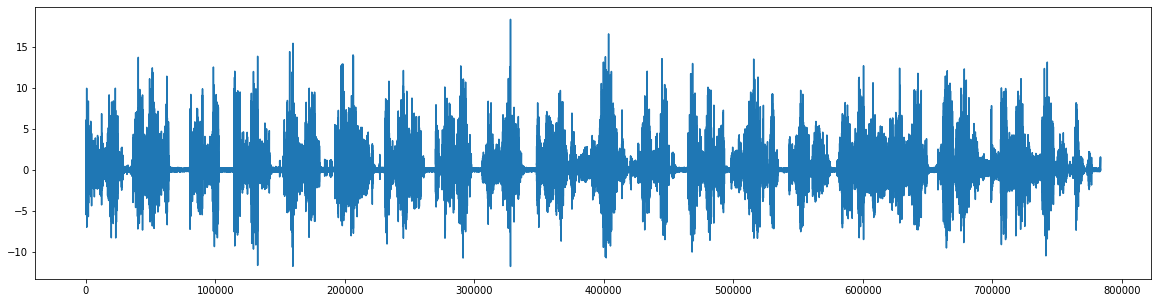

In [92]:
fig = plt.figure(figsize=(20,5))
plt.plot(emg[:,4])

# Calculate dx, dy

In [256]:
cursor_dx_dy = [(0,0)]
for i in range(len(behav["cursor"])):
    if i+1 < len(behav["cursor"]):
        # calculate from i to i+1
        dx = behav["cursor"][i+1][0] - behav["cursor"][i][0]
        dy = behav["cursor"][i+1][1] - behav["cursor"][i][1]
        cursor_dx_dy += [(dx,dy)]

In [257]:
len(cursor_dx_dy)

29300

# Input, output

In [264]:
X = pd.DataFrame({
    "R DELTOID": emg_downsamples[0],
    "R BICEPS BRACHII": emg_downsamples[1],
    "R TRICEPS BRACHII": emg_downsamples[2],
    "R FLEXOR CARPI RADIALIS": emg_downsamples[3],
    "R PALMARIS LONGUS": emg_downsamples[4],
    "R EXTENSOR CARPI RADIALIS": emg_downsamples[5]
})

In [266]:
# 마지막 EMG 데이터로는 예측할 label이 없으므로 삭제
X = X.iloc[0:len(X)]
Y = np.array(cursor_dx_dy)

In [267]:
X

,R DELTOID,R BICEPS BRACHII,R TRICEPS BRACHII,R FLEXOR CARPI RADIALIS,R PALMARIS LONGUS,R EXTENSOR CARPI RADIALIS
0,6.171203,2.638020,0.429678,0.561604,1.532313,1.599448
1,6.171203,2.638020,0.429678,0.561604,1.532313,1.599448
2,6.171203,2.638020,0.429678,0.561604,1.532313,1.599448
3,6.171203,2.638020,0.429678,0.561604,1.532313,1.599448
4,6.171203,2.638020,0.429678,0.561604,1.532313,1.599448
...,...,...,...,...,...,...
29295,1.415584,0.155676,0.455332,0.301279,0.375276,0.261823
29296,0.984428,0.146872,0.757229,0.191241,0.109166,0.159815
29297,0.868121,0.103724,0.767409,0.152484,0.132028,0.120191
29298,1.051079,0.102124,0.559608,0.216971,0.267347,0.214091


In [268]:
Y

array([[ 0,  0],
       [ 0,  0],
       [ 0,  0],
       ...,
       [ 0,  0],
       [-1,  0],
       [ 0,  0]])

In [269]:
print(len(X), len(Y))

29300 29300


In [248]:
from sklearn.model_selection import train_test_split

# LSTM

In [225]:
# https://pseudo-lab.github.io/Tutorial-Book/chapters/time-series/Ch4-LSTM.html

In [302]:
class LSTM(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers, out_features):
        super(LSTM, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers
        )
        self.out_features = out_features
        
        self.linear = nn.Linear(in_features=n_hidden, out_features=self.out_features)
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
        )
    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(
            sequences.view(len(sequences), self.seq_len, -1),
            self.hidden
        )
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
        return y_pred

In [303]:
def train_model(model, train_data, train_labels, val_data=None, val_labels=None, num_epochs=100, verbose = 10, patience = 10):
    loss_fn = torch.nn.L1Loss() #
    optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
    train_hist = []
    val_hist = []
    for t in range(num_epochs):

        epoch_loss = 0

        for idx, seq in enumerate(train_data): 

            model.reset_hidden_state() # seq 별 hidden state reset
            
            print(seq)
            print(seq.shape)
            # train loss
            seq = torch.unsqueeze(seq, 0)
            y_pred = model(seq)
            loss = loss_fn(y_pred[0].float(), train_labels[idx]) # 1개의 step에 대한 loss

            # update weights
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            epoch_loss += loss.item()

        train_hist.append(epoch_loss / len(train_data))

        if val_data is not None:

            with torch.no_grad():

                val_loss = 0

                for val_idx, val_seq in enumerate(val_data):

                    model.reset_hidden_state() # seq 별로 hidden state 초기화 

                    val_seq = torch.unsqueeze(val_seq, 0)
                    y_val_pred = model(val_seq)
                    val_step_loss = loss_fn(y_val_pred[0].float(), val_labels[val_idx])

                    val_loss += val_step_loss
                
            val_hist.append(val_loss / len(val_data)) # val hist에 추가

            ## verbose 번째 마다 loss 출력 
            if t % verbose == 0:
                print(f'Epoch {t} train loss: {epoch_loss / len(train_data)} val loss: {val_loss / len(val_data)}')

            ## patience 번째 마다 early stopping 여부 확인
            if (t % patience == 0) & (t != 0):
                
                ## loss가 커졌다면 early stop
                if val_hist[t - patience] < val_hist[t] :

                    print('\n Early Stopping')

                    break

        elif t % verbose == 0:
            print(f'Epoch {t} train loss: {epoch_loss / len(train_data)}')

            
    return model, train_hist, val_hist

In [321]:
train_x  = torch.from_numpy(X)

TypeError: expected np.ndarray (got DataFrame)

In [318]:
model = LSTM(
    n_features=6,
    n_hidden=4,
    seq_len=1, # ??
    n_layers=1,
    out_features=2,
)
model, train_hist, val_hist = train_model(
    model,
    torch.tensor(X.to_numpy(), dtype=torch.double),
    torch.tensor(Y, dtype=torch.double),
    num_epochs=100,
    verbose=10,
    patience=50
)


tensor([6.1712, 2.6380, 0.4297, 0.5616, 1.5323, 1.5994], dtype=torch.float64)
torch.Size([6])


RuntimeError: expected scalar type Double but found Float

In [285]:
torch.tensor(X.to_numpy()).shape

torch.Size([29300, 6])

tensor([[6.1712, 2.6380, 0.4297, 0.5616, 1.5323, 1.5994],
        [6.1712, 2.6380, 0.4297, 0.5616, 1.5323, 1.5994],
        [6.1712, 2.6380, 0.4297, 0.5616, 1.5323, 1.5994],
        ...,
        [0.8681, 0.1037, 0.7674, 0.1525, 0.1320, 0.1202],
        [1.0511, 0.1021, 0.5596, 0.2170, 0.2673, 0.2141],
        [0.5842, 0.1169, 0.3322, 0.1748, 0.6305, 0.2090]], dtype=torch.float64)

In [297]:
torch.unsqueeze(torch.tensor(X.to_numpy())[0], 0).shape

torch.Size([1, 6])

In [319]:
torch.tensor(X.to_numpy(), dtype = torch.DoubleTensor)

TypeError: tensor(): argument 'dtype' must be torch.dtype, not torch.tensortype

In [311]:
torch.tensor(X.to_numpy(), torch.double)

TypeError: tensor() takes 1 positional argument but 2 were given